In [1]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import FreqDist
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report
)
from tensorflow.keras.preprocessing import sequence
from gensim.models import Word2Vec
from tensorflow.keras.layers import (
    Dense,
    LSTM,
    Dropout,
    Embedding,
    Flatten,
    Bidirectional
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

#  constants for train and test data paths
TRAIN_FOLDER = 'aclImdb/train'
TEST_FOLDER = 'aclImdb/test'

In [2]:
def auc_score(y_true, y_pred):
    """Calculate area under ROC curve"""
    score = tf.py_function(roc_auc_score, (y_true, y_pred), float)
    return score


def load_data(path):
    """Load data from specified path.
    
    Args:
        path: path to review files.
    
    Returns:
        list: list of reviews.
        
    """
    data = []
    files = os.listdir(path)
    for i, f_name in enumerate(files):
        print(
            '\rReading from %s ...%.2f' % (path, float(i) / len(files)),
            end='',
            flush=True
        )
        with open(os.path.join(path, f_name), 'r', encoding='utf-8') as f:
            data.append(f.readline())
    print()
    return data


def conf_matrix_plot(true_l, pred_l, mask=('neg', 'pos')):
    """Plot confusion matrix.
    
    Args:
        true_l: true class lables for observations.
        pred_l: predicted class labels from model.
        mask (:obj:`tuple`, optional): labels for rows and columns
            of confusion matrix. Defaults to ('neg', 'pos').
        
    """
    matrx = pd.DataFrame(
        confusion_matrix(true_l, pred_l), columns=mask, index=mask
    )
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    plt.figure()
    sns.heatmap(matrx, cmap=cmap, annot=True, square=True)
    plt.title('Confusion matrix')

    
def token_process(
    text, s_words=None, min_l=3, stemming=False, 
    lemmatize=False, rem_punctuation=False
):
    """Token preprocessing function.
    
    Supported procedures are: stop words and punctuation marks
    removing, token length control, stemming, lemmatization.
    
    Args:
        text: list of tokens to process.
        s_words(:obj:`list`, optional): stop words to be removed
            from tokens. Defaults to None.
        min_l(int, optional): minimum token length to keep.
        stemming(bool, optional): for stemming enabling.
        lemmatize(bool, optional): for lemmatization enabling.
        rem_punctuation(bool, optional): for punctuation removing enabling.
    
    Returns:
        list: list of processed tokens.
    
    """
    s_words = [] if s_words is None else s_words
    signs = set('\'".,?!`')
    
    if rem_punctuation:
        text = filter(
            lambda x: len(set(x).intersection(signs)) == 0, text
        )
    
    text = filter(lambda x: (len(x)>=min_l) and (x not in s_words), text)
    
    if stemming:
        stemmer = PorterStemmer()
        text = map(lambda x: stemmer.stem(x), text)
    
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        text = map(lambda x: lemmatizer.lemmatize(x), text)
        text = map(lambda x: lemmatizer.lemmatize(x, pos='v'), text)
        
    return list(text)
    
    
def tokenizer(data, after_process=True, **kwargs):
    """Review tokenization function.
    
    Convert text representation of review to tokens.
    Then optionaly apply token preprocessing.
    
    Args:
        data: raw review in text format.
        after_process(bool, optional): for token preprocessing
            enabling.
        **kwargs: keyword arguments for token preprocessing
            function.
    
    Returns:
        list: tokenized review.
    
    """
    #     tokens = word_tokenize(data)
    tokens = re.findall(r'[a-zA-Z]+', data)
    tokens = [x.lower() for x in tokens]
    
    if after_process:
        stop_words = set(stopwords.words('english'))
        tokens = token_process(tokens, stop_words, **kwargs)
        
    return tokens


def get_rnn(data_shape, vocab_size, emb_shape=32, drop_prob=0.2, embedding=None):
    """Initializing neural network.
    
    Initializing model with one layer of bidirectional LSTM
    cells and two fully-connected layers. Applying dropout 
    after each hidden layer. Model can use custom weights 
    for word embedding layer.
    
    Args:
        data_shape: review shape.
        vocab_size: size of vocabulary.
        emb_shape(int, optional): embedding dimension.
        drop_prob(float, optional): dropout probability.
        embedding(:obj:`list`, optional): list of weights
            for custom embedding.
    
    Returns:
        tf.keras.Model: initialized LSTM model.
    
    """
    trainable = False if embedding is not None else True
    weights = [embedding] if embedding is not None else None
    model = Sequential()
    model.add(
        Embedding(
            vocab_size + 1,
            emb_shape,
            input_length=data_shape[0],
            weights=weights,
            trainable=trainable
        )
    )
    model.add(Dropout(drop_prob))
    
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Dropout(drop_prob))
    
    model.add(Flatten())
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(drop_prob))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

In [3]:
# load data and form class labels

pos_path_train = os.path.join(TRAIN_FOLDER, 'pos')
neg_path_train = os.path.join(TRAIN_FOLDER, 'neg')
pos_path_test = os.path.join(TEST_FOLDER, 'pos')
neg_path_test = os.path.join(TEST_FOLDER, 'neg')

comments = (
    load_data(pos_path_train)
    + load_data(neg_path_train)
    + load_data(pos_path_test)
    + load_data(neg_path_test)
)

labels = np.zeros([len(comments) // 2])
labels[: len(comments) // 4] += 1
labels = list(labels) * 2

df = pd.DataFrame({'comments': comments, 'sentiment': labels})
df = df.sample(frac=1.).reset_index(drop=True)
all_text = df['comments'].str.cat(sep=' ')
df.head()

Reading from aclImdb/train\pos ...1.00
Reading from aclImdb/train\neg ...1.00
Reading from aclImdb/test\pos ...1.00
Reading from aclImdb/test\neg ...1.00


,comments,sentiment
0,The film is partly a thriller and partly a pub...,1.0
1,This film on paper looked like it could possib...,0.0
2,"This movie is an abomination, and its making s...",0.0
3,Before I continue forth with the new millenniu...,1.0
4,I was also on hand for the premiere in Toronto...,1.0


<br>In the cell below presented first view of dataset. All reviews were splitted to tokens and all frequencies were calculated across whole dataset.</br>

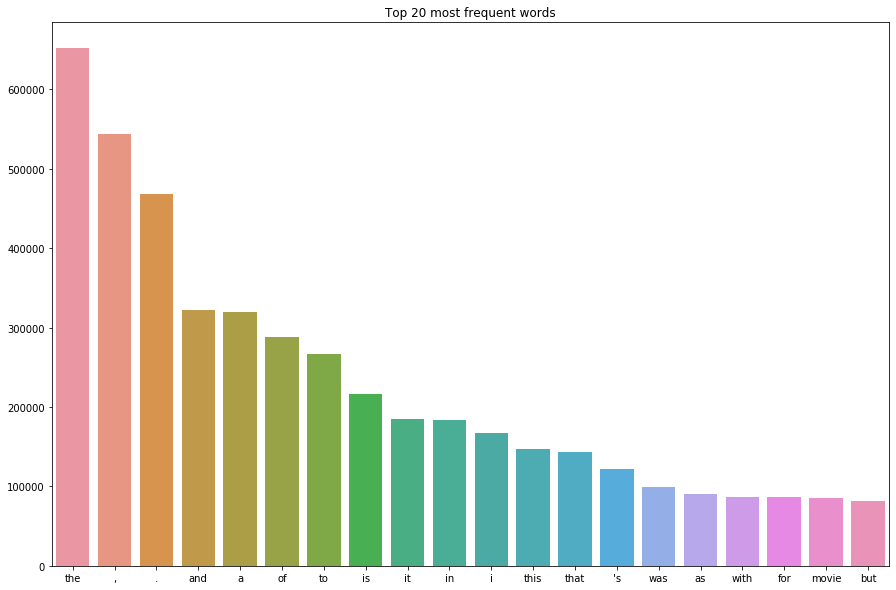

In [4]:
cleaned_text = BeautifulSoup(all_text).get_text()  # removing html tags

words = word_tokenize(cleaned_text)
words = [x.lower() for x in words]

frequencies = FreqDist(words)
words = sorted(frequencies, reverse=True, key=lambda x: frequencies[x])

plt.figure(figsize=(15, 10))
plt.title('Top 20 most frequent words')
sns.barplot(x=words[:20], y=[frequencies[x] for x in words[:20]])

<br>From the diagram above we can see that top positions in frequency list are received by stop words and punctuation marks.
They are not significant while classification, so we can remove them.</br>

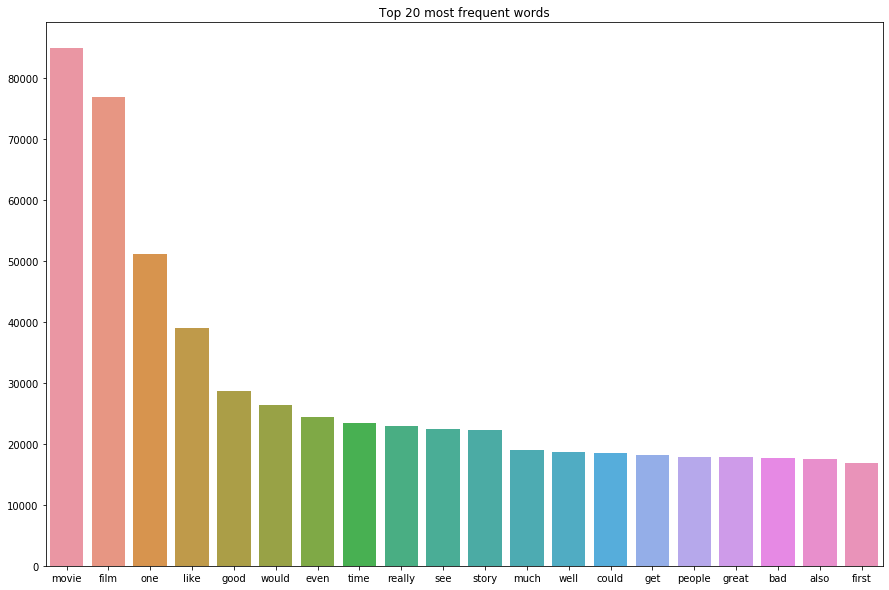

In [5]:
words = token_process(
    words, s_words=set(stopwords.words('english')), min_l=2, rem_punctuation=True
)

plt.figure(figsize=(15, 10))
plt.title('Top 20 most frequent words')
sns.barplot(x=words[:20], y=[frequencies[x] for x in words[:20]])

<br>To bring all words to the same form I applied lemmatization. Note that frequencies changed significantly even for top frequent words.</br>

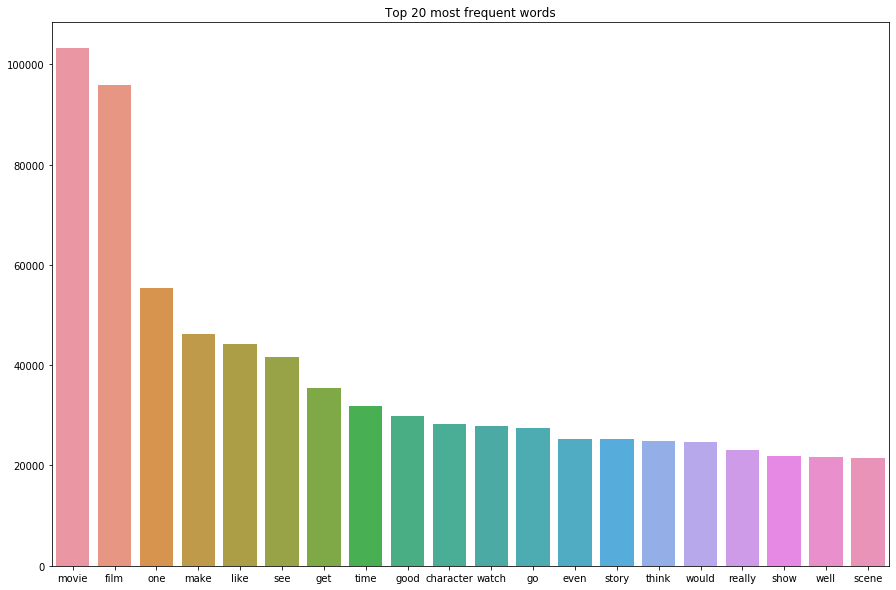

In [6]:
sentencies = tokenizer(cleaned_text, lemmatize=True, min_l=2)
frequencies = FreqDist(sentencies)
words = sorted(frequencies, reverse=True, key=lambda x: frequencies[x])

plt.figure(figsize=(15, 10))
plt.title('Top 20 most frequent words')
sns.barplot(x=words[:20], y=[frequencies[x] for x in words[:20]])

<br>To prepare data for classifier we must choose review length, because all records must have same dimension. We can`t choose maximum lenght, because it is big enough and our data will be too sparse if we use it.
From the histogram below we can notice that data distribution is positively skewed. So as length threshold I chossed quantile of level 0.95.</br>

Quantile of distribution:  3391.0
Reviews lengths description


count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: comments, dtype: float64

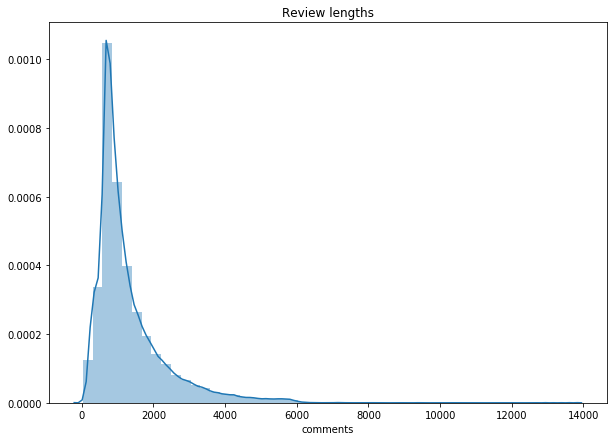

In [7]:
plt.figure(figsize=(10, 7))
review_lengths = df['comments'].map(lambda x: len(x))
plt.title('Review lengths')
sns.distplot(review_lengths)
print('Quantile of distribution: ', review_lengths.quantile(.95))
print('Reviews lengths description')
review_lengths.describe()

<br>In the cell below I applied splitting for training and test sets. Data preprocessed acording to results above. 
I used word2vec model to get vector representations of words.</br>

In [8]:
train_x, train_y = (
    df['comments'].iloc[:25000].values,
    df['sentiment'].iloc[:25000].values
)
test_x, test_y = (
    df['comments'].iloc[25000:].values,
    df['sentiment'].iloc[25000:].values
)

# Applying lemmatization
train_x = [tokenizer(x, lemmatize=True, min_l=2) for x in train_x]
test_x = [tokenizer(x, lemmatize=True, min_l=2) for x in test_x]

# Building word2vec model on reviews data
sentencies = train_x + test_x
w2v_model = Word2Vec(
    sentences=sentencies, size=100, window=6, min_count=1, workers=4
) 

# creating mapping of words to positions in frequency list
word_to_rank = dict(zip(words, it.count(start=1)))

# creating mapping of words to vector representations
word_embedding = [
    w2v_model.wv[w] if w in w2v_model.wv.vocab else np.zeros(100) 
    for w in word_to_rank.keys()
]
word_embedding.insert(0, np.zeros(100))

# preparing data for neural network
train_x = [list(map(lambda x: word_to_rank.get(x, 0), r)) for r in train_x]
test_x = [list(map(lambda x: word_to_rank.get(x, 0), r)) for r in test_x]

train_x = np.array(train_x)
test_x = np.array(test_x)
word_embedding = np.array(word_embedding)

max_review_len = int(review_lengths.quantile(.95))   

# padding all reviews to the same length
train_x = sequence.pad_sequences(train_x, maxlen=max_review_len, value=0, padding='pre')
test_x = sequence.pad_sequences(test_x, maxlen=max_review_len, value=0, padding='pre')

print(f'Train set shape: %s\nTest set shape: %s' % (train_x.shape, test_x.shape))

Train set shape: (25000, 3391)
Test set shape: (25000, 3391)


<br>As base classifier I used recurrent neural network with LSTM cells. LSTM is stands for long short term memory. This architecture is suits well for sequance type data, hence we can expect good perfomance in our case. This type of cells takes into account not only input data but previous cell state and output. It manages inputs with special nodes, such as: input gate, candidat cell state, forget gate, output gate, cell state and block output. Tipicaly this nodes consist of linear combination of corresponding cell inputs and nonlinearity being applied, except cell state and block output nodes. With this architecture we can extract inner features of sequance, such as positional relations of words in review, and avoid gradient vanishing problem.</br>

In [22]:
epochs, batch_size = 10, 120  # training parameters

# initializing model
rnn = get_rnn(
    train_x.shape[1:],  # review lenght
    len(word_to_rank),  # dictionary size
    emb_shape=100,  # number of dimensions of embedding space
    drop_prob=.5,
    embedding=word_embedding  # weights for embedding
)

rnn.compile(
    loss='binary_crossentropy',
    optimizer=Adam(clipnorm=1.),  # applying gradient clipping to prevent gradient explosion
    metrics=['accuracy', auc_score]
)
rnn.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_split=0.2)

pred = rnn.predict(test_x)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3391, 100)         8192000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 3391, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 3391, 100)         60400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 3391, 100)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 339100)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 2712808   
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                

<br>To monitor model training process I used two metrics accuracy and area under ROC curve. First metric is used, because our main goal is to lable reviews according to their sentiment polarity. With this metric me measure percentage of correctly guesed class labels. Since we solving binary classification task, area under ROC curve is a good measure of classification perfomance of the model. From model training log we can see that monitor metrics are getting better with more epochs envolved. Also you can notice that model achieved stable perfomance on training and validation sets.

After model training on training set and prediction of scores on test set we must choose threshold for class labeling.
I used ROC to get score level which delivers fair compromise between True Positive Rate and False Positive Rate.</br>

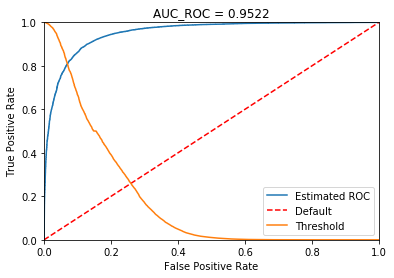

In [23]:
fpr, tpr, threshold = roc_curve(test_y, pred)
plt.title(f'AUC_ROC = %.4f' % roc_auc_score(test_y, pred))
plt.plot(fpr, tpr, label='Estimated ROC')
plt.plot([0, 1], [0, 1], 'r--', label='Default')
plt.plot(fpr, threshold, label='Threshold')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

<br>In cell below presented model evaluation metrics. Prediction threshold is choosed according to AUC plot. Developed model can gues correct review sentiment in 89% of cases.</br>

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88     12472
         1.0       0.88      0.90      0.89     12528

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



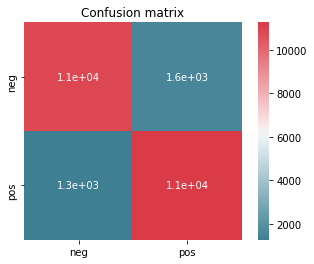

In [36]:
pred_l = [1 if x >= 0.56 else 0 for x in pred]
print(classification_report(test_y, pred_l))
conf_matrix_plot(test_y, pred_l)